In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# import inspect

import torch
import torch.distributions as dist
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from typing import Tuple

SEED=3012024

In [ ]:
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

In [ ]:
torch.manual_seed(SEED)


## using the provided resource as base architecture
class VAE(nn.Module):
    def __init__(self, hidden_dims, data_dim=784, device=DEVICE):
        super().__init__()
        assert len(hidden_dims) == 5, "Insufficiently number of dimensions!"
        self.data_dim = data_dim
        self.device = device
        # define IO
        self.in_layer = nn.Linear(data_dim, hidden_dims[0])
        self.out_layer = nn.Linear(hidden_dims[-1], data_dim)
        # hidden layer
        self.enc_h = nn.Linear(hidden_dims[0], hidden_dims[1])
        # define hidden and latent
        self.enc_mu = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.enc_sigma = nn.Linear(hidden_dims[1], hidden_dims[2])
        # hidden layer decoder
        self.dec_h = nn.Linear(hidden_dims[2], hidden_dims[-2])
        self.dec_layer = nn.Linear(hidden_dims[-2], hidden_dims[-1])
        self.to(device)

    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        h1 = F.relu(self.in_layer(x))
        h2 = F.relu(self.enc_h(h1))
        return self.enc_mu(h2), self.enc_sigma(h2)

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        h3 = F.relu(self.dec_h(z))
        h4 = F.relu(self.dec_layer(h3))
        return torch.sigmoid(self.out_layer(h4))

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        mu, logvar = self.encode(x.view(-1, self.data_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [ ]:
def train(model: VAE, epoch: int, train_loader: torch.utils.data.DataLoader, log_interval: int=25) -> list:
    model.train()
    train_loss = 0.
    train_loss_vals = []
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(model.device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(x)
        loss_val, ce, kld = loss(recon_batch, x, mu, logvar)
        loss_val.backward()
        train_loss += loss_val.item()
        train_loss_vals.append(loss_val.item())
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(f"Train epoch={epoch} [{batch_idx*len(x)}/{len(train_loader.dataset)}]\t loss={loss_val.item() / len(x)}")
            print(f"BCE={ce} KLD={kld}")
    print(f"===> epoch={epoch} avrg.loss={train_loss/len(train_loader.dataset)}")
    return train_loss_vals

In [ ]:
def test(model: VAE, epoch: int, test_loader: torch.utils.data.DataLoader) -> list:
    model.eval()
    test_loss = 0.
    test_loss_vals = []
    with torch.no_grad():
        for i, (x, _) in enumerate(test_loader):
            x = x.to(model.device)
            recon_batch, mu, logvar = model(x)
            test_loss_val, ce, kld = loss(recon_batch, x, mu, logvar)
            test_loss += test_loss_val.item()
            test_loss_vals.append(test_loss_val.item())
            # if i == 0: # TODO: do we want to persist images here?
            #     n = min(data.size(0), 8)
            #     comparison = torch.cat([x[:n], ])
    test_loss /= len(test_loader.dataset)
    print(f"===> Test loss={test_loss}")
    return test_loss_vals

In [ ]:
# lets use torch datasets with our data
class DatasetWrapper(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [ ]:
kwargs = {'num_workers': 1, 'pin_memory': True} if DEVICE=="cuda" else {}

batch_size = 128

train_data = datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST('../data', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size, shuffle=False, **kwargs)

100%|██████████| 9912422/9912422 [00:00<00:00, 382562191.12it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 40690525.30it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 177298725.78it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7034907.23it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [ ]:
EPOCHS=200

# 3.) modify the network architecture and try to obtain a better embedding
model = VAE(hidden_dims=[300, 50, 2, 50, 300]) # NOTE: 2D latent space
optimizer = optim.Adam(model.parameters(), lr=1e-3)


def loss(recon_x: torch.Tensor, x: torch.Tensor, mu: torch.Tensor, logvar: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    x = x.view(-1, 784)
    assert recon_x.shape[0] == x.shape[0] and recon_x.shape[-1] == x.shape[-1], "Shape Mismatch between reconstruction and x"
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="sum")
    KLD = -1/2 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD, BCE, KLD # = -ELBO

pre_trained = False
if pre_trained == True:
    model.load_state_dict(torch.load('./B_VAE_200', map_location=torch.device(DEVICE)))
else:
    train_loss_vals_total = []
    test_loss_vals_total = []
    for e in range(1, EPOCHS+1):
        train_loss_vals = train(model, epoch=e, train_loader=train_loader)
        test_loss_vals = test(model, epoch=e, test_loader=test_loader)
        train_loss_vals_total.append(train_loss_vals)
        test_loss_vals_total.append(test_loss_vals)

Train epoch=1 [0/60000]	 loss=545.0596923828125
BCE=69766.4765625 KLD=1.1629427671432495
Train epoch=1 [3200/60000]	 loss=235.1112518310547
BCE=29291.759765625 KLD=802.4807739257812
Train epoch=1 [6400/60000]	 loss=196.0651397705078
BCE=24648.4609375 KLD=447.87744140625
Train epoch=1 [9600/60000]	 loss=211.67971801757812
BCE=26799.396484375 KLD=295.6082763671875
Train epoch=1 [12800/60000]	 loss=198.31887817382812
BCE=25033.1328125 KLD=351.6829833984375
Train epoch=1 [16000/60000]	 loss=190.4363250732422
BCE=24036.220703125 KLD=339.6295471191406
Train epoch=1 [19200/60000]	 loss=197.79908752441406
BCE=24996.8046875 KLD=321.47943115234375
Train epoch=1 [22400/60000]	 loss=194.94032287597656
BCE=24588.5859375 KLD=363.7760009765625
Train epoch=1 [25600/60000]	 loss=180.12257385253906
BCE=22571.916015625 KLD=483.7735595703125
Train epoch=1 [28800/60000]	 loss=176.51185607910156
BCE=22040.72265625 KLD=552.7945556640625
Train epoch=1 [32000/60000]	 loss=186.97894287109375
BCE=23430.951171875

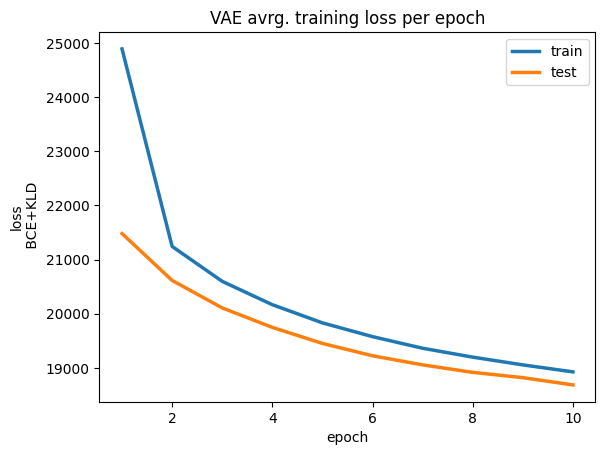

In [ ]:
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls)/batch_size for ls in train_loss_vals_total], lw=2.5, label="Train")
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls)/batch_size for ls in test_loss_vals_total], lw=2.5, label="Test")
plt.xlabel("Epochs")
plt.ylabel("Loss / -ELBO")
# plt.yscale("log")
plt.title("VAE with Bernoulli avrg. loss per epoch")
plt.legend()
plt.show()

In [ ]:
# encode entries
latent_coordinates = []
for data in train_data:
    # NOTE: we only obtain the mean for encoding and discard the log var
    latent_coordinates.append(model.encode(data[0].to(DEVICE).view(-1, 784))[0].cpu().detach().numpy())
latent_coordinates = np.array(latent_coordinates).reshape(60000, -1)


In [ ]:
latent_coordinates = latent_coordinates.reshape(60000, -1)

In [ ]:
train_labels = [data[1] for data in train_data]

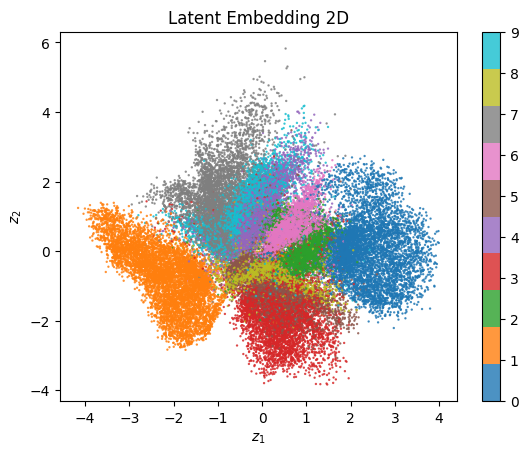

In [ ]:
# visualize 2D embedding of MNIST
plt.scatter(latent_coordinates[:,0], latent_coordinates[:,1], alpha=.8, s=0.5, c=train_labels, cmap="tab10")
plt.xlabel(r"$z_1$")
plt.ylabel(r"$z_2$")
plt.colorbar()
plt.title("Latent Embedding 2D")
plt.show()

Compared to the PPCA we obtain better spatial separation.
Numbers of the same label are grouped together in coherent clusters.


The architecture is modified by introducing another hidden layer in the encoder and decoder.

### Visualization by Gauss CDF

In [ ]:
## 2.) visualize across Gaussian CDF
n_cols = 12
z_space = torch.linspace(0.0001, 0.9999, n_cols) # for 5x5 grid
std_gauss = torch.distributions.normal.Normal(0, 1)

xx, yy = torch.meshgrid(z_space, z_space)


zz_gauss_cdf_vals = torch.dstack([std_gauss.icdf(xx), std_gauss.icdf(yy)]).reshape(-1, 2)
zz_gauss_cdf_vals.shape

tensor([[-3.7190, -3.7190],
        [-3.7190, -1.3347],
        [-3.7190, -0.9082],
        [-3.7190, -0.6044],
        [-3.7190, -0.3487],
        [-3.7190, -0.1142],
        [-3.7190,  0.1142],
        [-3.7190,  0.3487],
        [-3.7190,  0.6044],
        [-3.7190,  0.9082],
        [-3.7190,  1.3347],
        [-3.7190,  3.7190],
        [-1.3347, -3.7190],
        [-1.3347, -1.3347],
        [-1.3347, -0.9082],
        [-1.3347, -0.6044],
        [-1.3347, -0.3487],
        [-1.3347, -0.1142],
        [-1.3347,  0.1142],
        [-1.3347,  0.3487],
        [-1.3347,  0.6044],
        [-1.3347,  0.9082],
        [-1.3347,  1.3347],
        [-1.3347,  3.7190],
        [-0.9082, -3.7190],
        [-0.9082, -1.3347],
        [-0.9082, -0.9082],
        [-0.9082, -0.6044],
        [-0.9082, -0.3487],
        [-0.9082, -0.1142],
        [-0.9082,  0.1142],
        [-0.9082,  0.3487],
        [-0.9082,  0.6044],
        [-0.9082,  0.9082],
        [-0.9082,  1.3347],
        [-0.9082,  3

torch.Size([144, 2])

tensor([-3.7190, -3.7190])
tensor([-3.7190, -1.3347])
tensor([-3.7190, -0.9082])
tensor([-3.7190, -0.6044])
tensor([-3.7190, -0.3487])
tensor([-3.7190, -0.1142])
tensor([-3.7190,  0.1142])
tensor([-3.7190,  0.3487])
tensor([-3.7190,  0.6044])
tensor([-3.7190,  0.9082])
tensor([-3.7190,  1.3347])
tensor([-3.7190,  3.7190])
tensor([-1.3347, -3.7190])
tensor([-1.3347, -1.3347])
tensor([-1.3347, -0.9082])
tensor([-1.3347, -0.6044])
tensor([-1.3347, -0.3487])
tensor([-1.3347, -0.1142])
tensor([-1.3347,  0.1142])
tensor([-1.3347,  0.3487])
tensor([-1.3347,  0.6044])
tensor([-1.3347,  0.9082])
tensor([-1.3347,  1.3347])
tensor([-1.3347,  3.7190])
tensor([-0.9082, -3.7190])
tensor([-0.9082, -1.3347])
tensor([-0.9082, -0.9082])
tensor([-0.9082, -0.6044])
tensor([-0.9082, -0.3487])
tensor([-0.9082, -0.1142])
tensor([-0.9082,  0.1142])
tensor([-0.9082,  0.3487])
tensor([-0.9082,  0.6044])
tensor([-0.9082,  0.9082])
tensor([-0.9082,  1.3347])
tensor([-0.9082,  3.7190])
tensor([-0.6044, -3.7190])
t

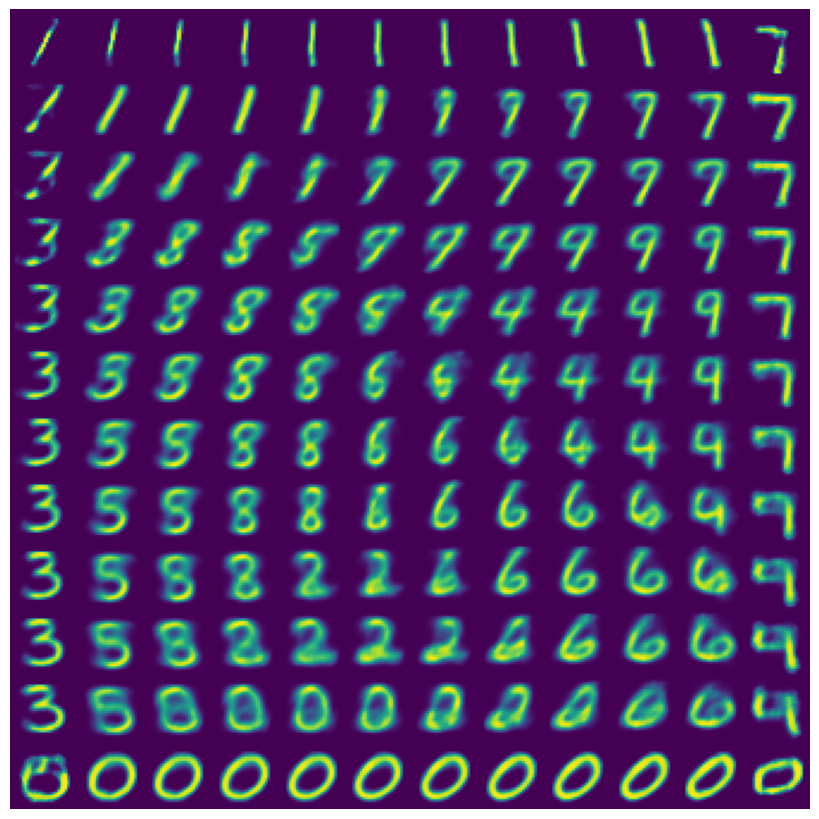

In [ ]:
fig, ax = plt.subplots(nrows=n_cols, ncols=n_cols, figsize=(8,8))

k = 0
for i in range(n_cols):
    for j in range(n_cols):
        _zz = zz_gauss_cdf_vals[k]
        reconstruction = model.decode(_zz.to(DEVICE)).cpu().detach().numpy()
        img = reconstruction.reshape((28,28))
        ax[i, j].imshow(img)
        ax[i, j].set_axis_off()
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        k += 1
# plt.suptitle("MNIST reconstruction")
plt.tight_layout(w_pad=0., pad=0., h_pad=0.)
plt.show()


In [ ]:
def marginal_likelihood(data, model, N=128):
    log_p_xs = torch.zeros(len(data))
    for i, (image, _) in enumerate(data):
        mu, logvar = model.encode(image.to(DEVICE).view(-1, 784))
        mu = mu.cpu().detach()
        logvar = logvar.cpu().detach()
        var = torch.exp(logvar)
        q = dist.MultivariateNormal(mu, var * torch.eye(2))
        z = q.sample((N,))
        log_p_z = dist.MultivariateNormal(torch.zeros(2), torch.eye(2)).log_prob(z)
        log_q_z = q.log_prob(z)
        lam = model.decode(z.to(DEVICE)).cpu().detach()
        lam = torch.clamp(lam, clamp_threshold, 1-clamp_threshold) # Vi clamper for at undgå inf værdier i normaliseringskonstanten
        log_p_cb = torch.sum((-1) * F.binary_cross_entropy(lam, image.view(-1, 784).repeat(N, 1, 1), reduction="none") + log, axis=2)
        log_something = log_p_cb + log_p_z - log_q_z
        log_p_x = -np.log(N) + torch.logsumexp(log_something, dim=0)
        log_p_xs[i] = log_p_x[0]
    return log_p_xs.mean()


In [ ]:
# Det virker måske rigtigt nok. Den er ihvertfald omkring ELBO.
print('marginal likelihood:', marginal_likelihood(test_data, model, N=128))